In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

from sklearn import preprocessing
from sklearn.utils import check_X_y,check_array
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel

import random
import time
import dataclasses
from typing import List,Union
import pickle

import warnings
warnings.filterwarnings('ignore')

### 準備

In [2]:
# データの前準備
csv_df = pd.read_csv('../input/tsta_a_1791676_sm7407.csv')

# 分析データクラスの定義
@dataclasses.dataclass
class MaterialDataset:
    dataset_name: Union[str,None] = None
    x_name_list: Union[List[str],None] = None
    y_name_list: Union[List[str],None] = None
    data: Union[pd.DataFrame,None] = None


# 不要列を削除
drop = ['ID', '2% proof stress (Mpa)','Tensile strength (Mpa)']
csv_df = csv_df.drop(drop, axis=1)

# データクラスの作成
dataset = MaterialDataset()
dataset.dataset_name = 'tsta_a_1791676_sm7407'
dataset.x_name_list = list(csv_df.columns[:-1])
dataset.y_name_list = list(csv_df.columns[-1:])

# 重複データの平均値化
csv_df = csv_df.groupby(dataset.x_name_list)[dataset.y_name_list].agg(lambda x: x.unique().mean())
csv_df = csv_df.reset_index()

dataset.data = csv_df 

csv_df

,X,n,Fe (wt%),Mn (wt%),Si (wt%),Al (wt%),Mg (wt%),Ti (wt%),Cu (wt%),Cr (wt%),Zn (wt%),Elongation (%)
0,1,1,0.18,0.35,0.10,95.58,3.50,0.05,0.08,0.05,0.125,18.0
1,1,1,0.20,0.01,0.20,96.78,2.50,0.00,0.02,0.25,0.050,12.0
2,1,1,0.20,0.05,0.13,95.63,3.50,0.10,0.05,0.25,0.100,11.0
3,1,1,0.20,0.05,0.13,96.78,2.50,0.00,0.05,0.25,0.050,12.0
4,1,1,0.20,0.25,0.20,95.88,3.10,0.08,0.05,0.15,0.100,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
110,3,8,0.25,0.30,0.20,96.90,2.05,0.08,0.08,0.08,0.075,3.0
111,3,8,0.25,0.45,0.20,94.70,4.00,0.08,0.05,0.15,0.125,3.0
112,3,8,0.35,0.05,0.20,97.68,1.45,0.00,0.10,0.05,0.125,1.0
113,3,8,0.35,0.10,0.15,98.33,0.80,0.00,0.10,0.05,0.125,2.0


In [33]:
# 評価関数の準備
class EI():
    def __init__(self, xi :float = 0):
        # xi can also use 0.01
        self.xi = xi
    def calc_ac(self, X, model, y_best):
        mean, std = model.pred_dist(X)
        z = (mean - y_best - self.xi)/std
        return (mean - y_best - self.xi) * norm.cdf(z) + std * norm.pdf(z), mean , std
    
class RandomValue():
    def __init__(self):
        pass
    def calc_ac(self, X, model, y_best):
        np.random.seed(0)
        value = np.random.randint(0, 1, len(X)).reshape(-1,1)
        return value, value , value 

In [34]:
# 予測モデルの準備
class BoModel():
    def __init__(self):
        pass

    def fit(self, X,Y):
        X, Y = check_X_y(X, Y, accept_sparse=True, y_numeric=True)
        kernel =  ConstantKernel() * RBF()+ WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-10, 1e1))
        self.model = GaussianProcessRegressor(kernel, alpha=0).fit(X, Y)
        return self

    def pred_dist(self, X):
        X = check_array(X, accept_sparse=True)
        pred_value = self.model.predict(X,return_std =True)
        y_test, std= pred_value[0], pred_value[1]

        return y_test,std

In [35]:
class OptBenchmark:
    def __init__(self):
        self.index_collection = []
        self.y_best_trend_collection = []
        self.y_pred_mean_collection = []
        self.y_pred_std_collection = []
        self.total_time = None
        self.batch_size = None

    def calc_pool_opt(self,model, mat_dataset, ac_class, n_exp_initial: int = 10, n_ensemble: int = 5, result_save_name :str="result", iterations :int= -1):
        
        # 計算時間の算出：計算開始時間の格納
        start_time = time.time()

        # データの取得
        x_all = mat_dataset.data[mat_dataset.x_name_list].values
        y_all = mat_dataset.data[mat_dataset.y_name_list].values.ravel()
        all_data_num = mat_dataset.data[mat_dataset.x_name_list].shape[0]

        np.random.seed(0)
        seed_list = [int(x) for x in np.random.randint(0, 10000, n_ensemble)]

        # 最適化計算セットの繰り返し
        for ensemble_num in range(n_ensemble):
            print(f'ensumble num = {ensemble_num}, initializing seed = {str(seed_list[ensemble_num])}')
            random.seed(seed_list[ensemble_num])

            # index_learn_pool：未実験の候補のリスト
            # index_obserbed : 実験済みのリスト。初期実験点の数をランダムにサンプリング
            index_learn_pool = list(np.arange(all_data_num))
            index_observed = random.sample(index_learn_pool, n_exp_initial)
            index_learn_pool = [i for i in index_learn_pool if i not in index_observed]
            
            # 結果を格納するリスト
            y_best_trend_list = []
            y_pred_mean_list = []
            y_std_mean_list = []

            # iterationsの数値が-1の場合は全ての候補を評価。そうでない場合には設定しただけの実験を実施
            if iterations == -1:
                iterations = len(index_learn_pool)
            elif iterations > len(index_learn_pool):
                iterations = len(index_learn_pool)
            for _ in np.arange(iterations):
                next_index = None
                x_observed = x_all[index_observed,:]
                y_observed = y_all[index_observed]

                x_scaler = preprocessing.StandardScaler()
                y_scaler = preprocessing.StandardScaler()            
                x_train_std = x_scaler.fit_transform(x_observed)
                x_all_std = x_scaler.transform(x_all)
                y_observed_std = y_scaler.fit_transform(y_observed.reshape(-1,1)).ravel()
                y_best_std = np.max(y_observed_std)
                model.fit(x_train_std, y_observed_std)

                # 獲得関数を計算して次の候補indexを選択。選択されたindexを実験済みに追加。未実験リストから削除
                ac_value_array, y_pred_mean_array, y_pred_std_array = ac_class.calc_ac(x_all_std, model, y_best_std)
                next_index = self._sample_select(ac_value_array, index_learn_pool, index_observed)
                index_observed.append(next_index)
                index_learn_pool.remove(next_index)
                
                y_pred_mean = y_scaler.inverse_transform(y_pred_mean_array[next_index].reshape(-1,1))
                y_std_mean = y_scaler.inverse_transform(y_pred_std_array[next_index].reshape(-1,1))

                y_best_trend_list.append(np.max(y_observed))
                y_pred_mean_list.append(y_pred_mean[0][0])
                y_std_mean_list.append(y_std_mean[0][0])
            else:
                y_observed = y_all[index_observed]
                y_best_trend_list.append(np.max(y_observed))
                
                self.index_collection.append(index_observed)
                self.y_best_trend_collection.append(y_best_trend_list)
                self.y_pred_mean_collection.append(y_pred_mean_list)
                self.y_pred_std_collection.append(y_std_mean_list)
            
        self.total_time = time.time() - start_time
        
        if result_save_name is not None:
            with open(result_save_name, 'wb') as f:
                pickle.dump(self, f)

        return self

    def _sample_select(self,ac_value_array, index_learn_pool, index_observed):
        max_ac = np.max(ac_value_array[index_learn_pool])
        max_pool_index = np.where(ac_value_array == max_ac)[0].tolist()
        max_pool_index = [i for i in max_pool_index if i not in index_observed]

        # 同じ獲得関数の値がある場合にはランダムに候補を選択
        next_index = random.sample(max_pool_index,1)[0]
        
        return next_index 

    def calc_avg_performance(self):
        result_dic = {'y_best_trend':self._calc_ave_array(self.y_best_trend_collection),
                    'y_pred_mean':self._calc_ave_array(self.y_pred_mean_collection),
                    'y_pred_std':self._calc_ave_array(self.y_pred_std_collection)
                    }

        return result_dic

    def _calc_ave_array(self, result_list):

        avg_array = np.zeros(len(result_list[0])) 
        for one_result in result_list:
            avg_array += np.array(one_result)
        avg_array = avg_array / len(result_list)
        return avg_array

## 最適化計算の実施

In [36]:
# 計算設定
iterations = 300
n_ensemble = 3

model_dic = {'GP':BoModel()}
ac_dic = {'EI':EI(),'Random':RandomValue()}
eval_list = ['random']
dataset_list = [dataset]

In [37]:
# 実験セット
for model_name,model in model_dic.items():
    for data in dataset_list:
        for ac_name, ac in ac_dic.items():
            bm_opt = OptBenchmark()
            result_save_name = f'{model_name}_{ac_name}_{data.dataset_name}_{n_ensemble}ensemble'     
            print(result_save_name)
            bm_opt.calc_pool_opt(model, data, ac, n_ensemble =n_ensemble, result_save_name =result_save_name,iterations = iterations )

GP_EI_tsta_a_1791676_sm7407_3ensemble
ensumble num = 0, initializing seed = 2732
ensumble num = 1, initializing seed = 9845
ensumble num = 2, initializing seed = 3264
GP_Random_tsta_a_1791676_sm7407_3ensemble
ensumble num = 0, initializing seed = 2732
ensumble num = 1, initializing seed = 9845
ensumble num = 2, initializing seed = 3264


## 結果の可視化

In [40]:
def plot_best_trend(perfomance_dataset_dic,baseline_dataset=None, plot_pred = True):

    fig = plt.figure(figsize=(12,12))
    ax0 = fig.add_subplot(111)

    if baseline_dataset is not None:
        n_b_data = len(baseline_dataset.data)
        best_value = np.max(baseline_dataset.data[baseline_dataset.y_name_list].values)

        ax0.plot(np.linspace(1, n_b_data, n_b_data), np.full(n_b_data,best_value),'--',color='black',linewidth = 3)    

    color_list = ["r", "b", "g", "y", "m", "c"]
    i = 0
    for perfomance_k, perfomance_i in perfomance_dataset_dic.items():
        n_p_data = len(perfomance_i['y_best_trend'])
        y_trend = perfomance_i['y_best_trend']

        font = font_manager.FontProperties(family='Arial', size = 26, style='normal')
        ax0.plot(np.arange(n_p_data) + 1, y_trend, label = perfomance_k, color = color_list[i], linewidth=3)
        ax0.legend(prop = font)
        ax0.set_xlim([0, 100])
        i += 1

    if plot_pred is True:
        for perfomance_k, perfomance_i in perfomance_dataset_dic.items():
            n_p_data = len(perfomance_i['y_pred_mean'])
            y_pred = perfomance_i['y_pred_mean']

            ax0.plot(np.arange(n_p_data) + 1, y_pred,'--', label = perfomance_k, color = color_list[i], linewidth=3)    
            y_low = y_pred - 1.96 * perfomance_i['y_pred_std']
            y_high = y_pred + 1.96 * perfomance_i['y_pred_std']
            ax0.fill_between(np.arange(n_p_data) + 1, y_low,y_high, color = color_list[i], alpha=0.2)

        
    #ax0.set_xscale('log')

def plot_same_ac_value_trend(perfomance_dataset_dic,plot_type = 'same_value_pred_count'):

    fig = plt.figure(figsize=(12,12))
    ax0 = fig.add_subplot(111)

    color_list = ["r", "b", "g", "y", "m", "c"]
    i = 0
    for perfomance_k, perfomance_i in perfomance_dataset_dic.items():
        n_p_data = len(perfomance_i[plot_type])
        ax0.plot(np.arange(n_p_data) + 1, perfomance_i[plot_type], label = perfomance_k, color = color_list[i], linewidth=3)
        
        i += 1
    
    font = font_manager.FontProperties(family='Arial', size = 26, style='normal')
    ax0.legend(prop = font)
    ax0.set_xlim([0, 200])

計算時間 GP_EI_tsta_a_1791676_sm7407_3ensemble： 22.58442211151123
計算時間 GP_Random_tsta_a_1791676_sm7407_3ensemble： 19.34565806388855


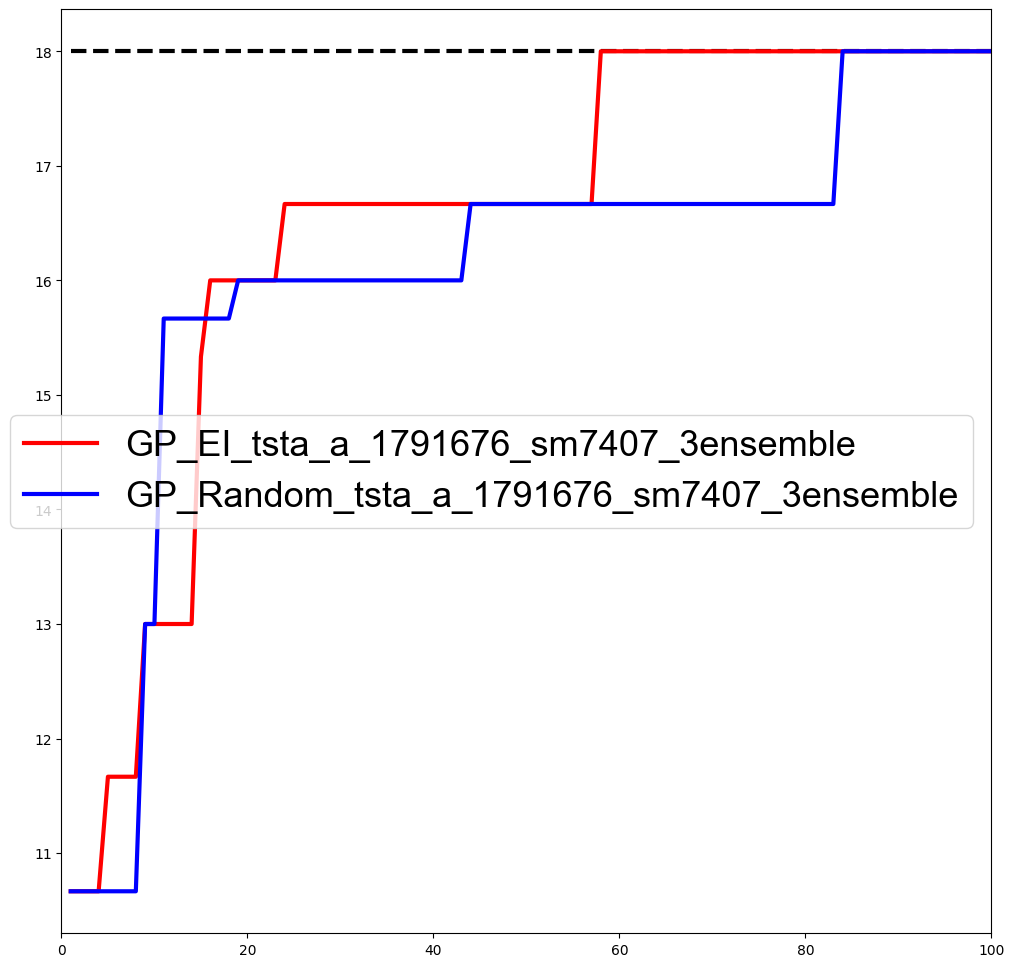

In [41]:
exp_name_list1 = ['GP_EI_tsta_a_1791676_sm7407_3ensemble'
                ,'GP_Random_tsta_a_1791676_sm7407_3ensemble'
                ] 

perfomance_dataset_dic = {}
for exp_name in exp_name_list1:
    with open(exp_name, 'rb') as f:
        result = pickle.load(f)
        print(f'計算時間 {exp_name}：',result.total_time)
        performance_result = result.calc_avg_performance()
        perfomance_dataset_dic[exp_name] = performance_result

plot_best_trend(perfomance_dataset_dic,dataset,plot_pred = False)